In [2]:
import pandas as pd
import sys
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## Study the index future contact trading and it's relationship to CSI 300 index:
    - IF is the index future contract linked to CSI 300 index
    - The main goal is to find out if index future contact trading info today can have any prediction power for tomorrow CSI index change.

#### Common functions

In [3]:
def read_idx_future():
    df_future =pd.read_csv('data/future_IF.csv', encoding="gb18030")
    df_future=df_future.rename(columns={'Unnamed: 0':'dealer'})
    df_future['datetime']=pd.to_datetime(df_future['datetime'], format='%Y%m%d')
    return df_future

def get_idx_future_top_traders(df_future, n):
    df_trader_vol= pd.DataFrame(df_future.groupby('dealer')['volume'].sum())
    df_trader_vol = df_trader_vol.sort_values(by='volume', ascending=False)
    return df_future[ df_future['dealer'].isin(df_trader_vol.index[:n])]

    df_trader_vol['volume'][n]


def get_total_trade_vol_top_dealers(df_future):
    df_trader_vol= pd.DataFrame(df_future.groupby('dealer')['volume'].sum())
    df_trader_vol = df_trader_vol.sort_values(by='volume', ascending=False)
    df =pd.DataFrame(columns=['n_top_dealers', 'percent_trade_volume'])
    total_trade_vol=df_future['volume'].sum()
    for n in range(0, len(df_future['dealer'].unique()),5):
        df.loc[len(df)] ={"n_top_dealers":n,"percent_trade_volume":df_trader_vol['volume'][:n].sum()/total_trade_vol}
    
    return df

def plot_one(df, char_type,x_col, y_col, title, color='skyblue'):
    plt.figure(figsize=(20, 5))
    if char_type=='barplot':
        sns.barplot(x=x_col, y=y_col, data=df, color=color)
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

def plot_n(df, n, x_col, y_cols, titles,colors):
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(20, 12))
    #for ax in list(axes):
    for i in range(n):
        sns.barplot(data=df, x=x_col, y=y_cols[i],ax=axes[i], color=colors[i])
        axes[i].set_title(titles[i])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

def cal_IC(df_idx, df_future):
    future_cols=df_future.columns.drop(['dealer','datetime'])
    future_cols_without_dealer=df_future.columns.drop(['dealer'])
    df_future_top_by_date=df_future[future_cols_without_dealer].groupby('datetime').sum()
    ics = df_future_top_by_date[future_cols][:-1].corrwith(df_idx['next_day_ret'][:-1], method='pearson')
    df_ic=pd.DataFrame(ics)
    df_ic.reset_index(inplace=True)
    df_ic.columns=['Column','IC']
    return df_ic

def cal_corr(df_idx,df_future_top):
    df_corr= pd.DataFrame(columns=['dealer','column', 'Correlation', 'Sum'])
    top_dealers=df_future_top['dealer'].unique()
    future_cols=df_future_top.columns.drop(['dealer','datetime'])
    for dealer in top_dealers:
        #dealer='中信期货'
        future_cols=list(df_future_top.columns.drop(['dealer','datetime']).values)
        df_future_dealer=df_future_top[df_future_top['dealer']==dealer]
        df_idx_future_dealer =df_idx.merge(df_future_dealer, left_index=True, right_on=['datetime'], how='right')

        df_idx_future_dealer=df_idx_future_dealer[future_cols +['next_day_ret']]
        #print(len(df_idx_future_dealer))
        #print(df_idx_future_dealer.tail())

        df_idx_future_dealer=df_idx_future_dealer[:-1].fillna(0)
        #print(df_idx_future_dealer.tail())
        df_corr_dealer=df_idx_future_dealer[future_cols].corrwith(df_idx_future_dealer['next_day_ret'])
        #print(df_corr_dealer)
                
        for x in df_corr_dealer.index:
            df_corr.loc[len(df_corr)] ={"dealer":dealer,'column':x, 'Correlation':df_corr_dealer[x], 'Sum':df_future_dealer[x].sum()}
        
    return df_corr


# Load data
    - future contract data into df_future
    - CSI index data from Yahoo into df_idx

In [4]:
df_future= read_idx_future()
last_date=df_future[-1:]['datetime'].dt.strftime('%Y-%m-%d').values[0]

df_idx =yf.download('000300.SS', start='2021-01-04', end=last_date)
df_idx = df_idx.droplevel('Ticker',axis=1)
df_idx['next_day_ret'] =df_idx['Close'].pct_change().shift(-1)
print(df_idx.tail())


C:\Users\mingl\AppData\Local\Temp\ipykernel_62328\2197789480.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_idx =yf.download('000300.SS', start='2021-01-04', end=last_date)
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open  Volume  \
Date                                                                     
2025-06-13  3864.179932  3889.159912  3853.820068  3881.489990  172500   
2025-06-16  3873.800049  3876.169922  3853.620117  3853.620117  137300   
2025-06-17  3870.379883  3880.419922  3860.409912  3875.179932  122300   
2025-06-18  3874.969971  3881.350098  3854.659912  3871.649902  127500   
2025-06-19  3843.090088  3872.939941  3834.949951  3870.050049  130300   

Price       next_day_ret  
Date                      
2025-06-13      0.002490  
2025-06-16     -0.000883  
2025-06-17      0.001186  
2025-06-18     -0.008227  
2025-06-19           NaN  


### Correlation and IC analysis between future contract trading data and CSI index change next day

#### The following analysis shows that
- Top 50 dealers contribute to 97.24% of total trading volume
- Top 100 dealers contribute to 99.73% of total trading volume

- Top 50 dealers will be more analysis in this notebook.

<class 'pandas.core.frame.DataFrame'>
Index: 38070 entries, 0 to 46302
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   dealer         38070 non-null  object        
 1   volume         38070 non-null  float64       
 2   volchange      38070 non-null  float64       
 3   buyvol         38070 non-null  float64       
 4   buyvolchange   38070 non-null  float64       
 5   sellvol        38070 non-null  float64       
 6   sellvolchange  38070 non-null  float64       
 7   net_vol_diff   38070 non-null  int64         
 8   datetime       38070 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 2.9+ MB
None


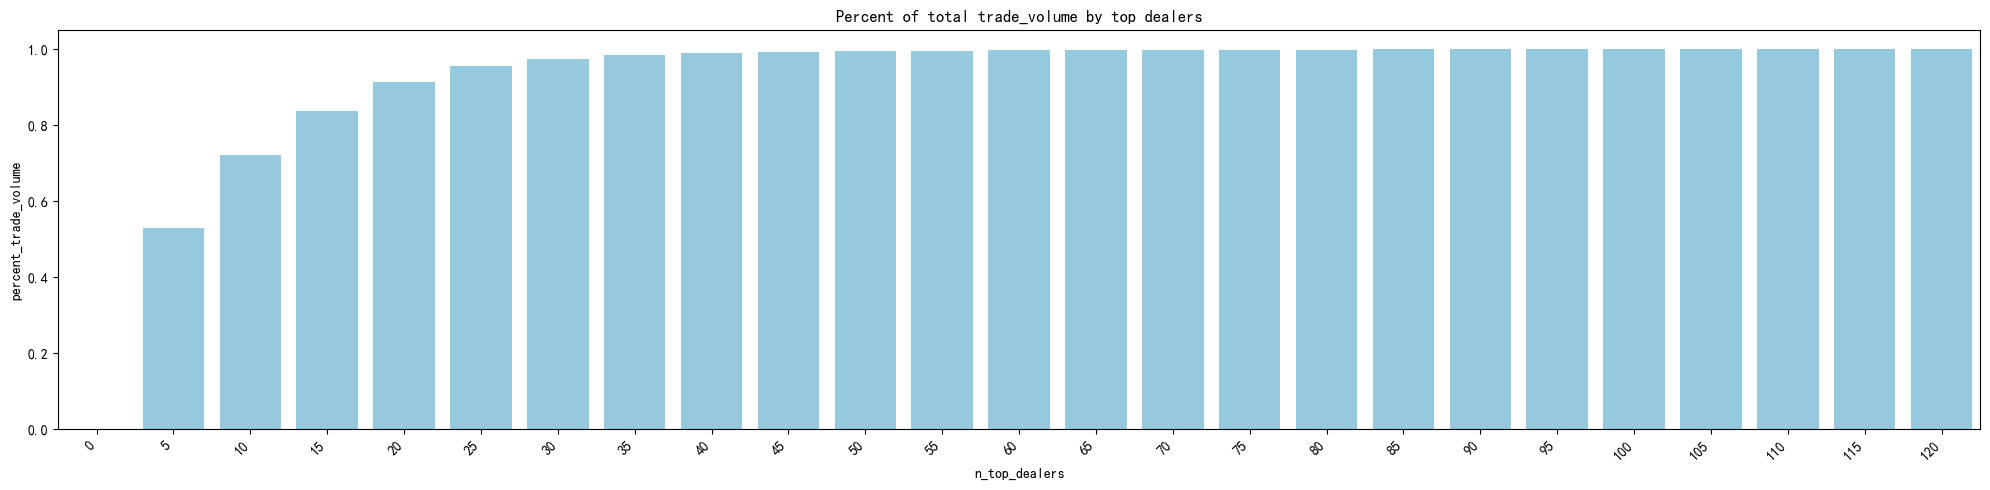

In [5]:
df_vol_percent=get_total_trade_vol_top_dealers(df_future) 
plot_one(df_vol_percent,'barplot',x_col='n_top_dealers', y_col='percent_trade_volume', title='Percent of total trade_volume by top dealers', color='skyblue')
df_future_top=get_idx_future_top_traders(df_future,50)
top_dealers=df_future_top['dealer'].unique()
print(df_future_top.info())



#### Find out the Information Coefficient (IC) between different future data columns of all dealers and CSI index change next data.
    - IF future contract volume seem to have highest IC with CSI index change next day
    - The future contract trading volume change has highest IC with CSI index change next day. Future contact buy volume and sell volume have high IC as well.
    - Surprisingly, the net trade volume has very small IC with the  CSI index change next day

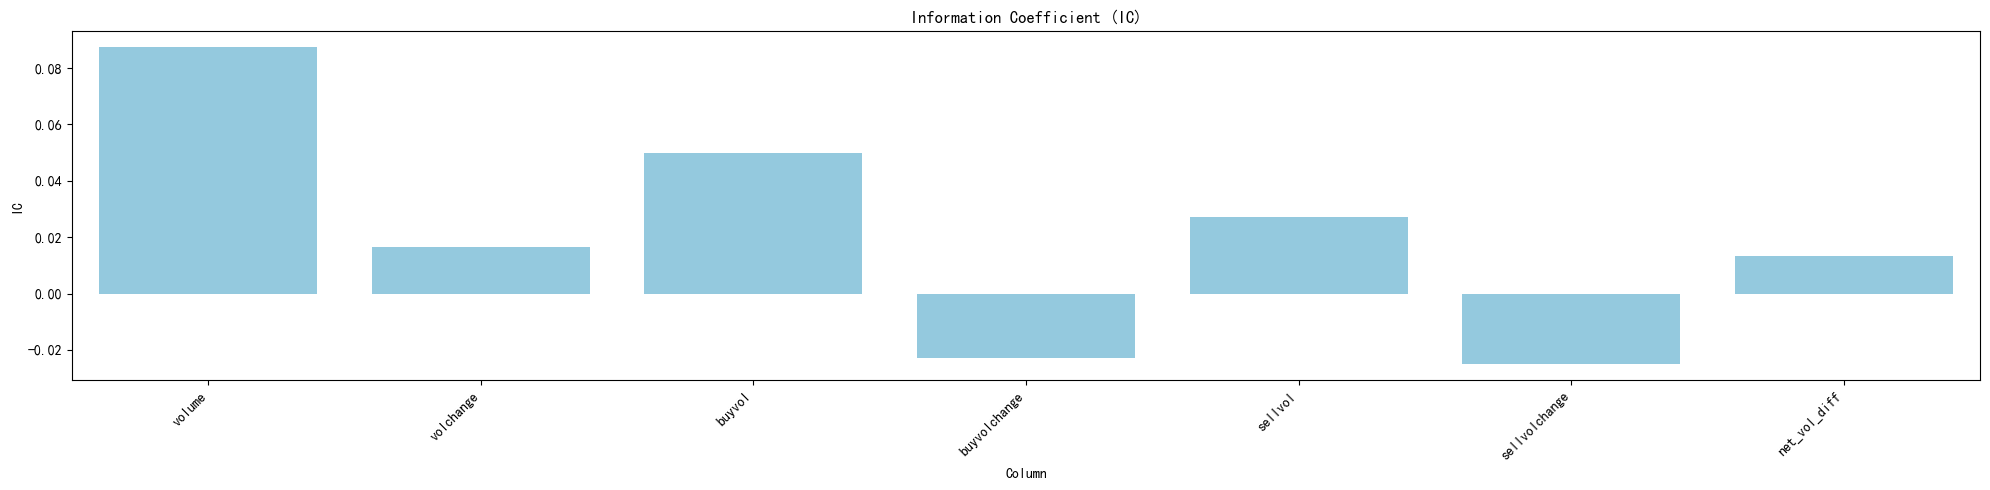

: 

In [ ]:
df_ic = cal_IC(df_idx, df_future_top)
plot_one(df_ic,'barplot',x_col='Column', y_col='IC', title='Information Coefficient (IC)', color='skyblue')

### check out if the net-future-vol is correlated to the next day's sp_idx

d:\PythonEnvs\qlib\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\PythonEnvs\qlib\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


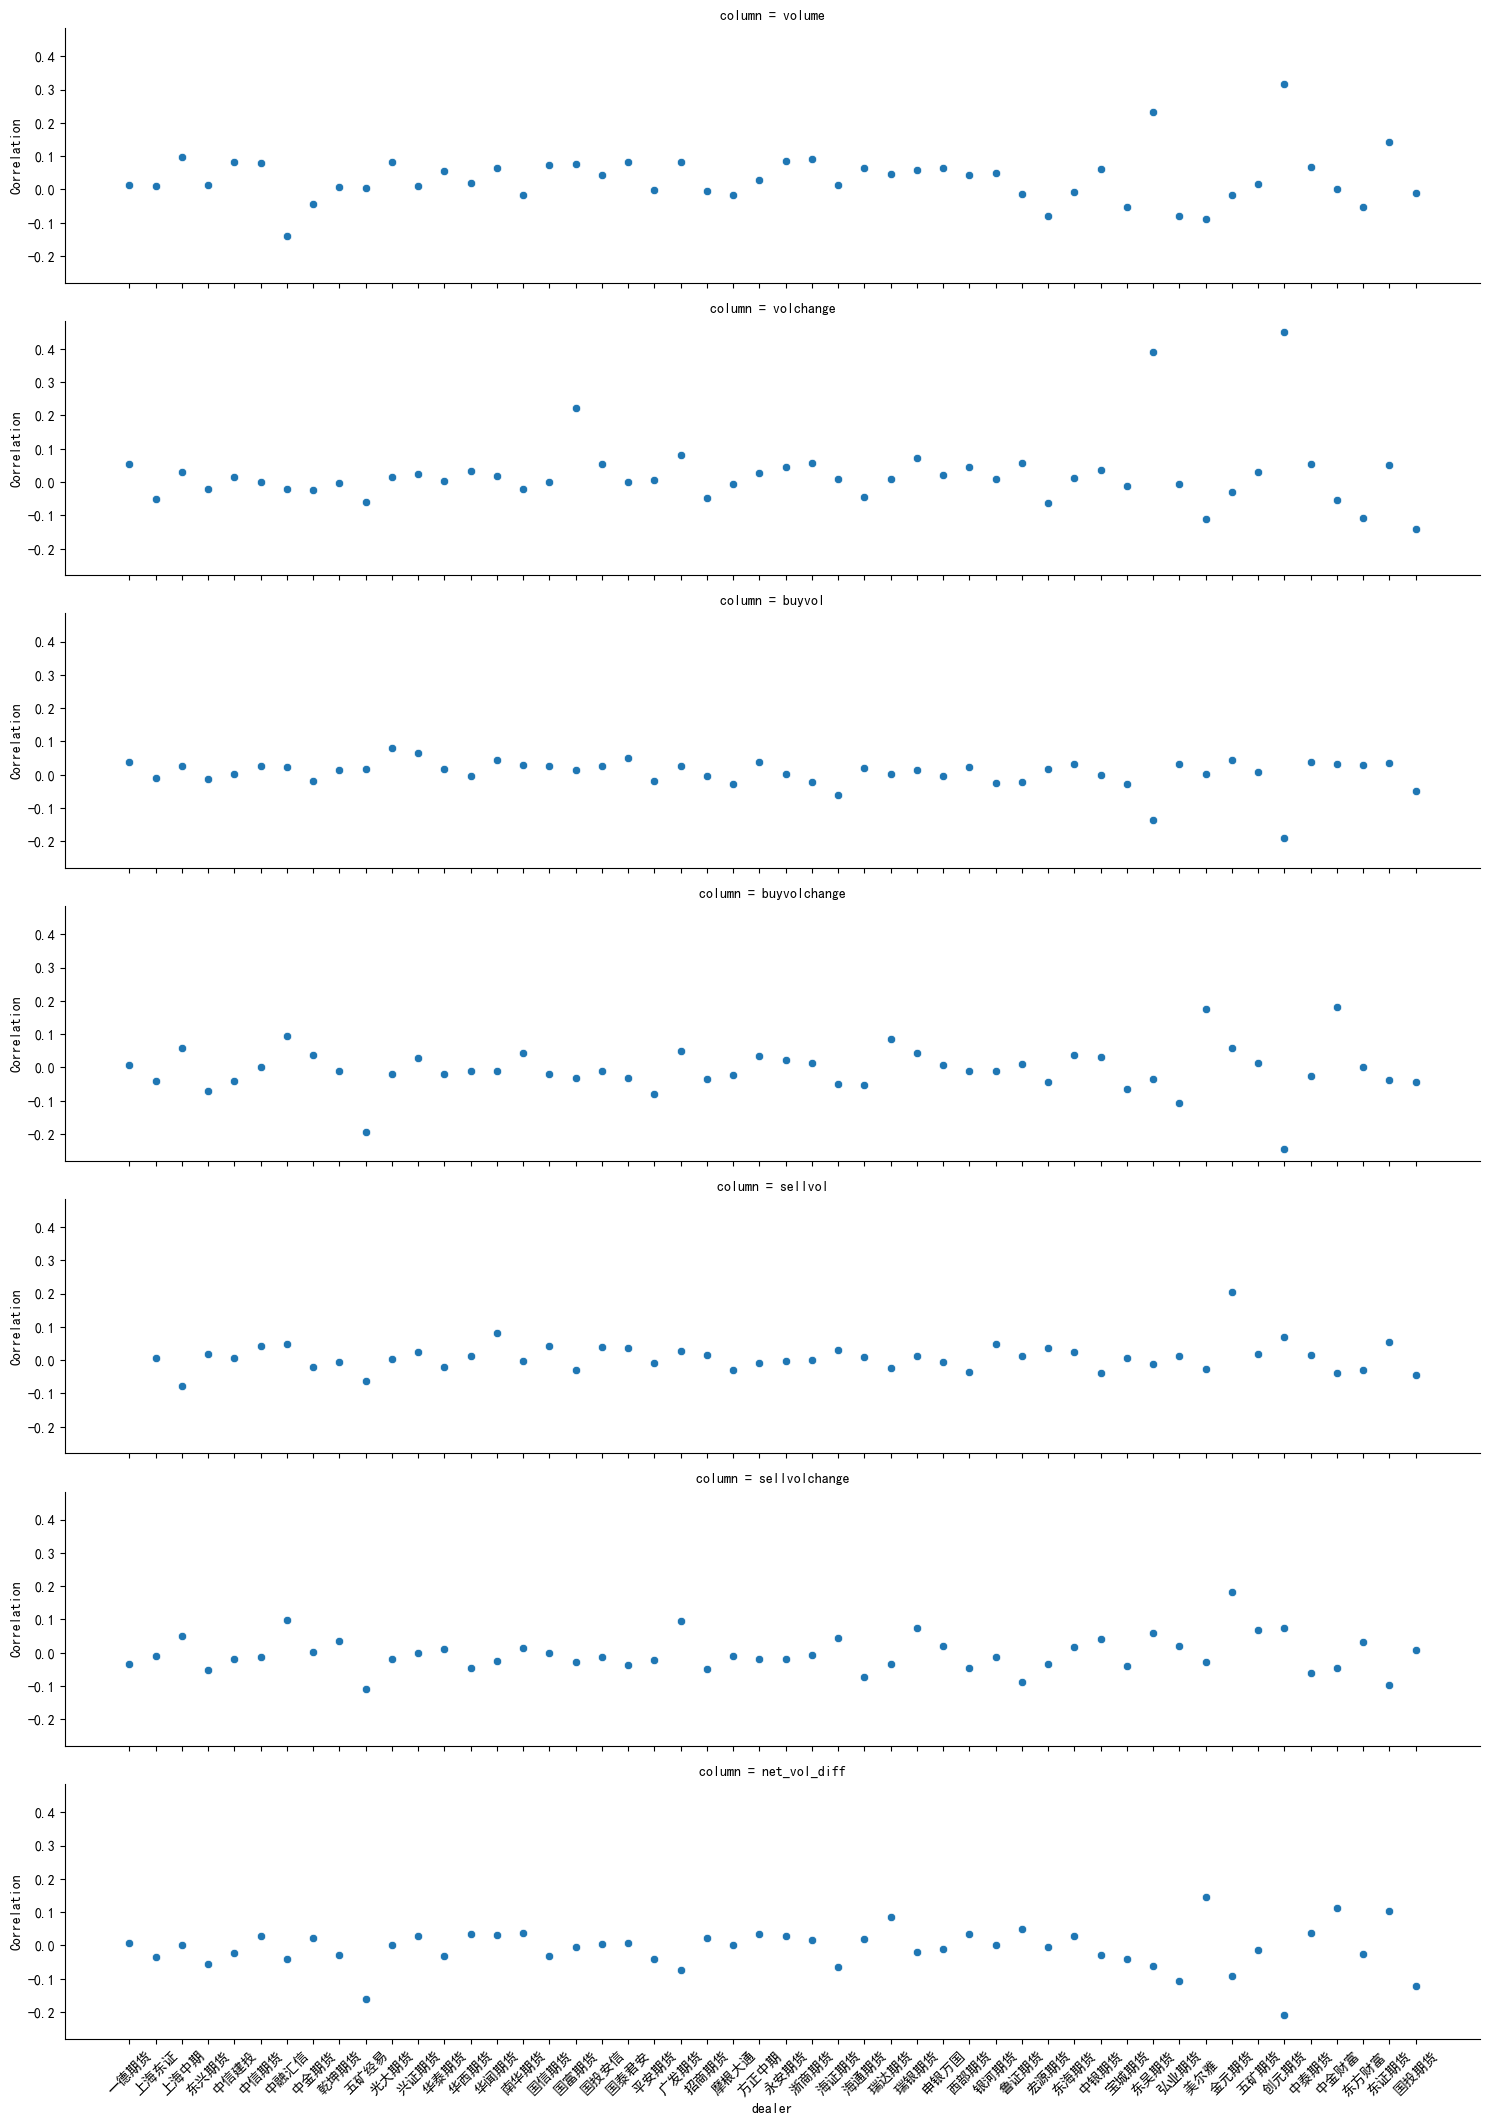

In [6]:

df_corr=cal_corr(df_idx, df_future_top)
g=sns.relplot(
    data=df_corr, 
    x="dealer", y="Correlation", row='column', facet_kws={'sharex': True}, height=3,aspect=5,

)
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelright=True)

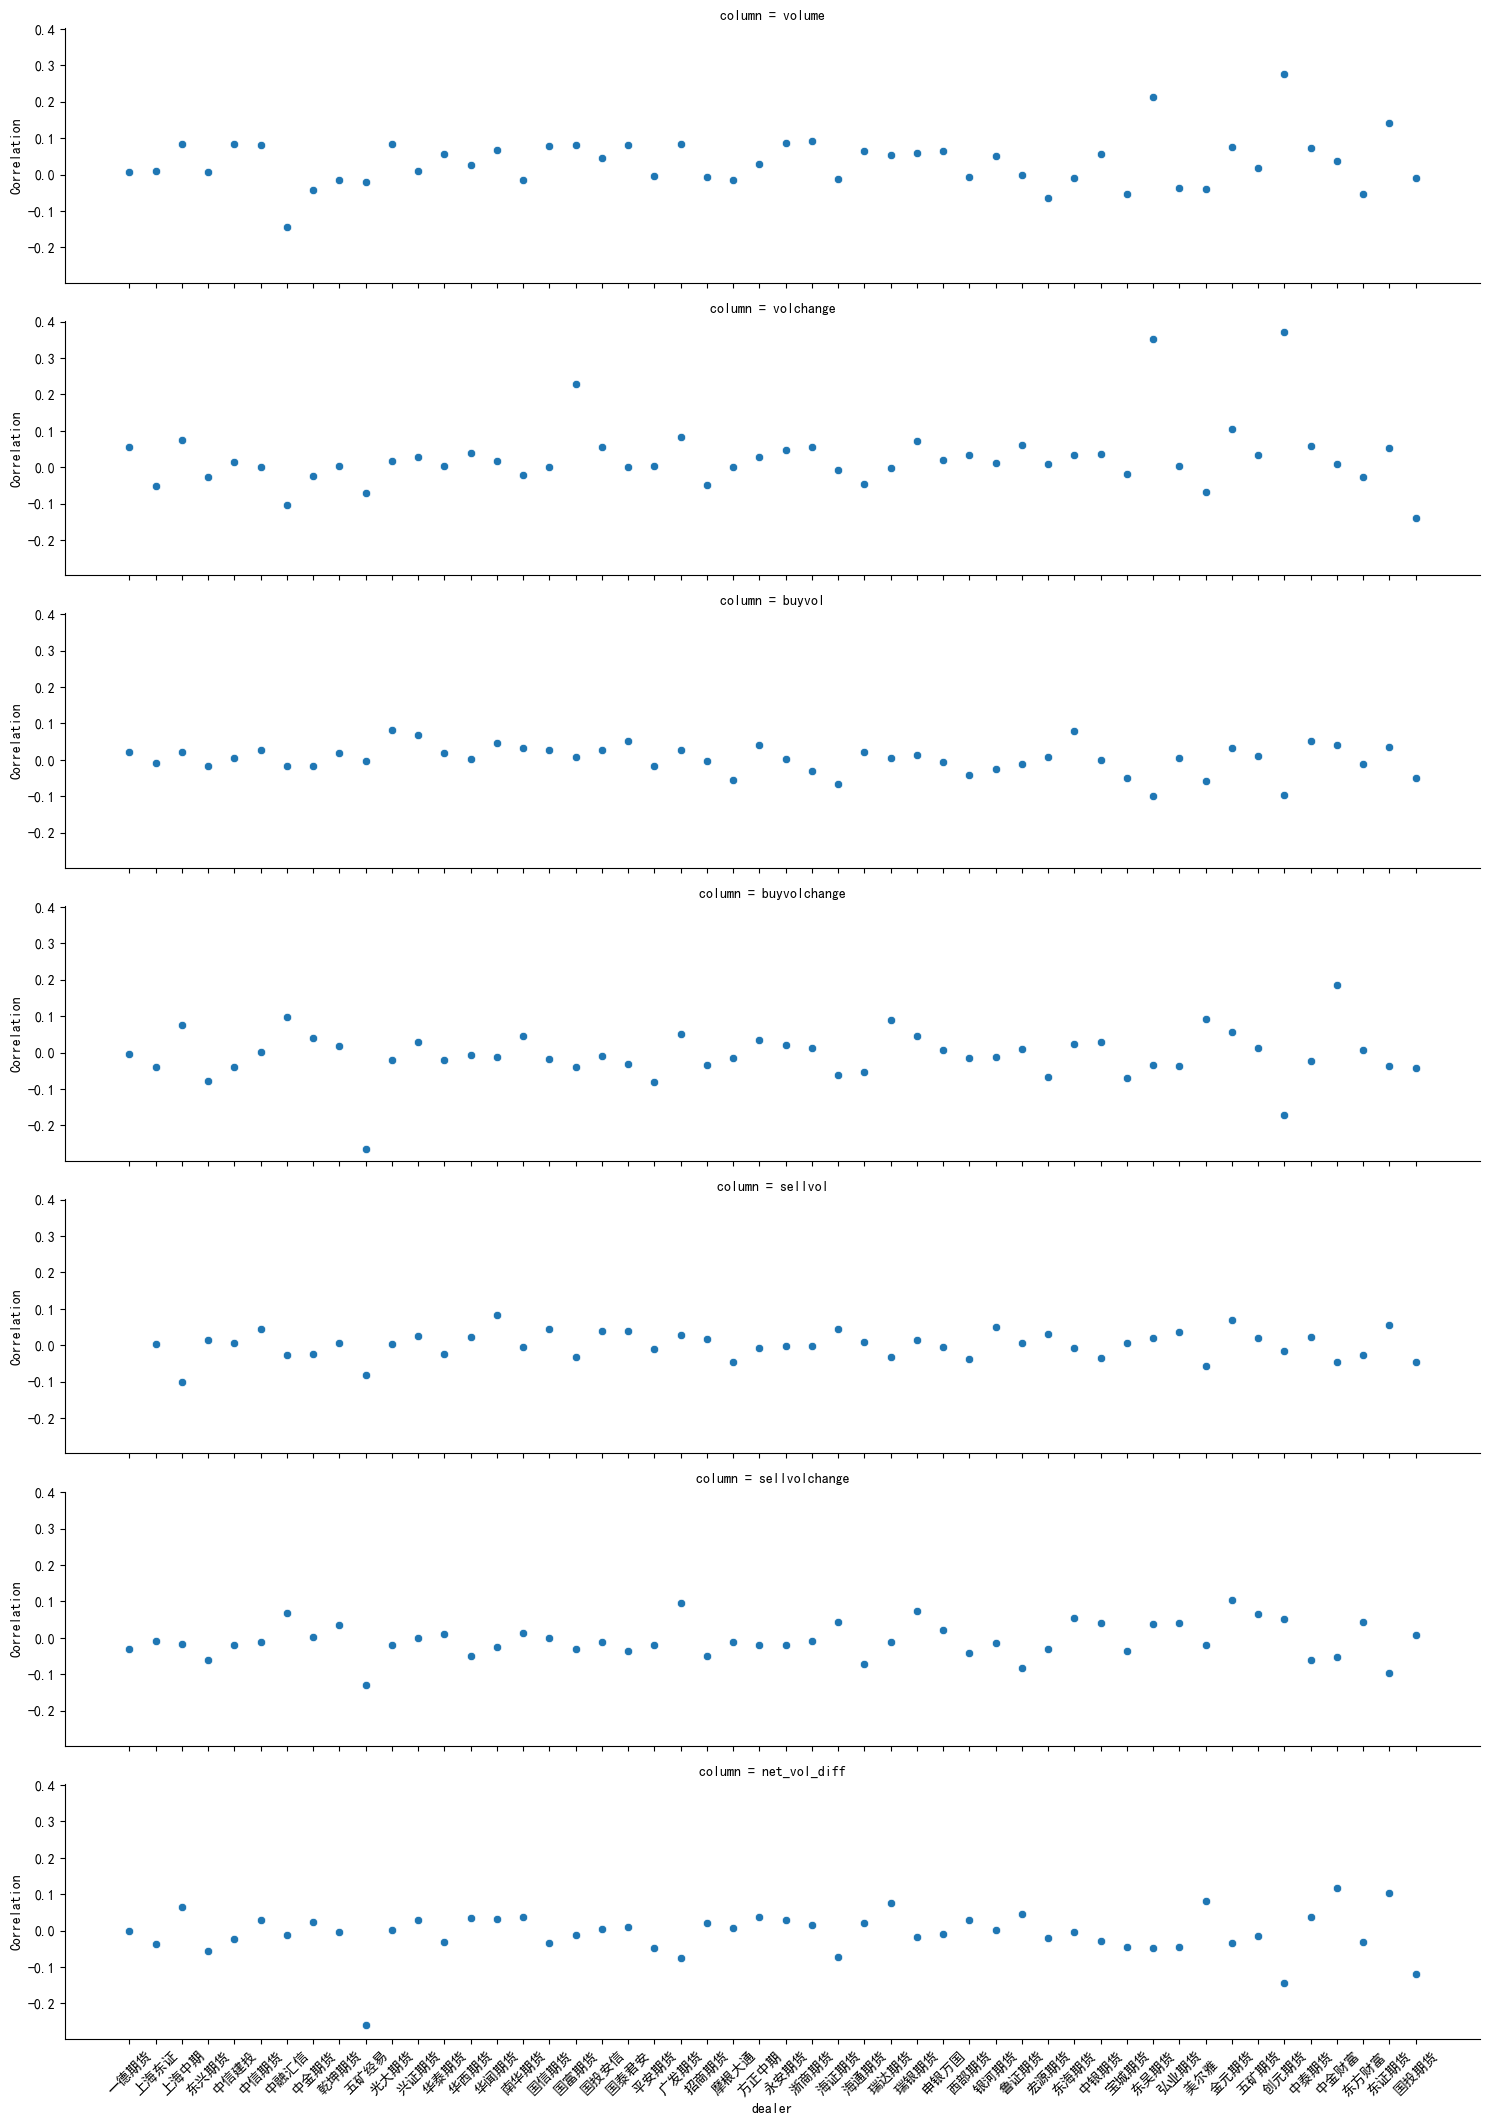

### Zoom in to see the correlation between future contract volume and CSI index change next day
    - those will highest future contract volume don't have the highest correlation 

C:\Users\mingl\AppData\Local\Temp\ipykernel_62328\3484752466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_by_vol['Abs_Correlation'] =abs(df_corr_by_vol['Correlation'])


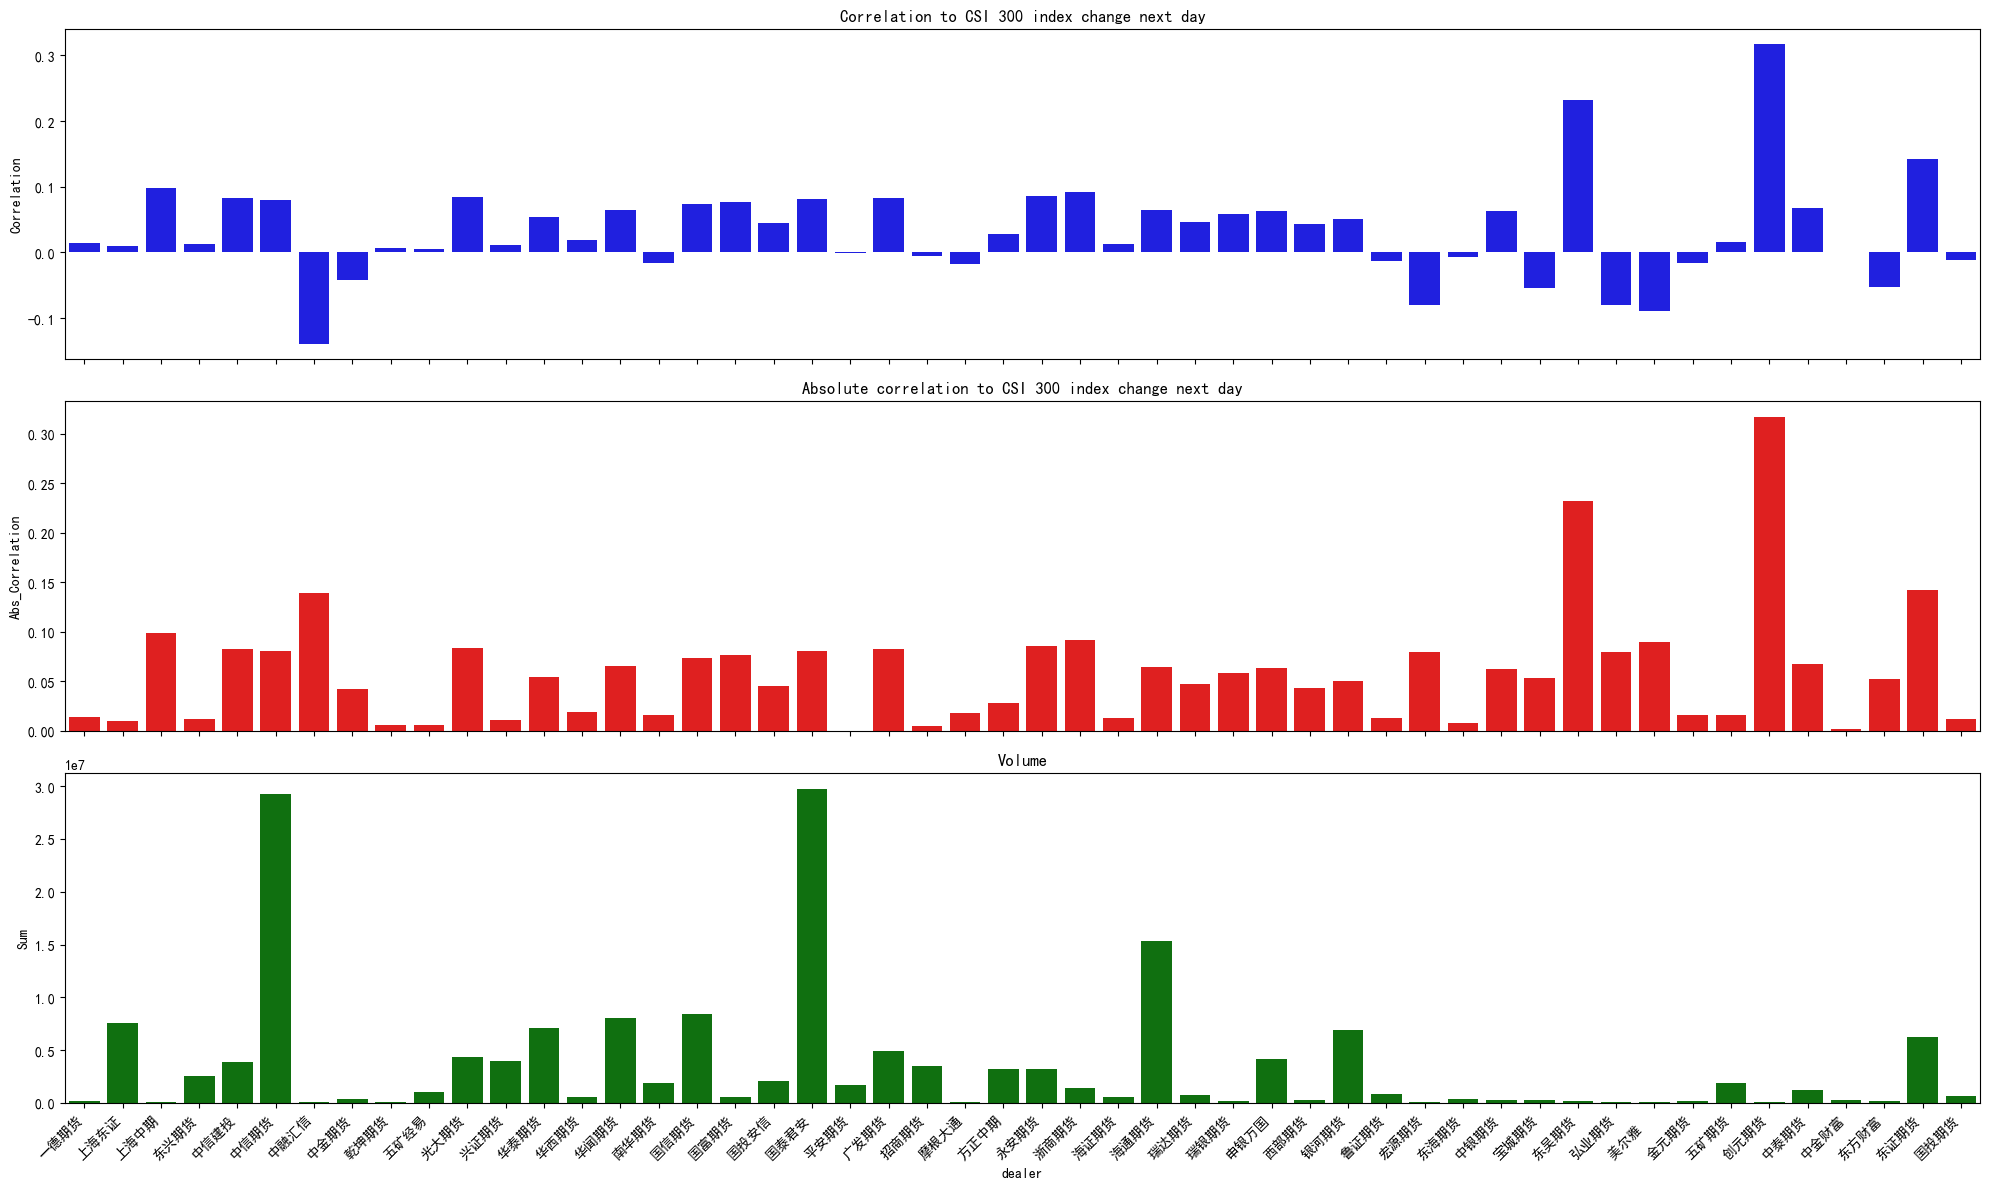

In [7]:

df_corr_by_vol= df_corr[df_corr['column']=='volume']
df_corr_by_vol['Abs_Correlation'] =abs(df_corr_by_vol['Correlation'])

plot_n(df_corr_by_vol,n=3, x_col='dealer', y_cols=['Correlation','Abs_Correlation','Sum'],titles=['Correlation to CSI 300 index change next day','Absolute correlation to CSI 300 index change next day','Volume'], colors=['blue','red','green'])


In [89]:
print(df_future_top.head())

  dealer   volume  volchange   buyvol  buyvolchange  sellvol  sellvolchange  \
0   一德期货   1244.0       71.0  10270.0        -220.0      0.0            0.0   
1   上海东证  11453.0     1641.0   6165.0        -174.0  20206.0         -173.0   
2   上海中期    198.0      -62.0      0.0           0.0      0.0            0.0   
3   东兴期货   6661.0     -748.0   2287.0         -74.0   1737.0          -32.0   
5   中信建投   2789.0     -521.0   1530.0        -235.0   5910.0         -266.0   

   net_vol_diff   datetime  
0          -220 2021-01-04  
1            -1 2021-01-04  
2             0 2021-01-04  
3           -42 2021-01-04  
5            31 2021-01-04  


In [8]:
print(df_future_top.columns.drop(['dealer','datetime'])  )

Index(['volume', 'volchange', 'buyvol', 'buyvolchange', 'sellvol',
       'sellvolchange', 'net_vol_diff'],
      dtype='object')


### Prepare data for machine learning model study

In [9]:
print(df_idx.head())

Price             Close         High          Low         Open  Volume  \
Date                                                                     
2021-03-11  5128.220215  5138.410156  5020.580078  5024.560059  189600   
2021-03-12  5146.379883  5153.669922  5086.819824  5153.669922  201000   
2021-03-15  5035.540039  5120.879883  4992.399902  5116.120117  204200   
2021-03-16  5079.359863  5084.310059  5009.950195  5054.410156  161400   
2021-03-17  5100.859863  5123.549805  5020.129883  5062.770020  149200   

Price       next_day_ret  
Date                      
2021-03-11      0.003541  
2021-03-12     -0.021537  
2021-03-15      0.008702  
2021-03-16      0.004233  
2021-03-17      0.008020  


In [10]:
def pivote_df_future(df_future_top):
    df_future_pivots=[]
    for col in df_future_top.columns.drop(['dealer','datetime']):
        df_future_pivot=df_future_top.pivot(index='datetime', columns='dealer', values=col)
        df_future_pivot=df_future_pivot.fillna(0)
        df_future_pivot.columns= [x +f'_{col}' for x in df_future_pivot.columns]
        df_future_pivots.append(df_future_pivot)

    df_future_pivoted = pd.concat(df_future_pivots, axis=1)
    return df_future_pivoted

df_future_pivoted =pivote_df_future(df_future_top)
df_idx_with_future_trades =df_idx.merge(df_future_pivoted, left_index=True, right_index=True, how='left').fillna(0)
df_idx_with_future_trades.dropna(inplace=True)
print(df_idx_with_future_trades.tail(1))


                  Close         High          Low         Open  Volume  \
Date                                                                     
2025-06-19  3843.090088  3872.939941  3834.949951  3870.050049  130300   

            next_day_ret  一德期货_volume  上海东证_volume  上海中期_volume  东兴期货_volume  \
Date                                                                           
2025-06-19           0.0          0.0          0.0          0.0          0.0   

            ...  海证期货_net_vol_diff  海通期货_net_vol_diff  瑞达期货_net_vol_diff  \
Date        ...                                                            
2025-06-19  ...                0.0              472.0                0.0   

            瑞银期货_net_vol_diff  申银万国_net_vol_diff  美尔雅  _net_vol_diff  \
Date                                                                   
2025-06-19              107.0             1315.0                 0.0   

            西部期货_net_vol_diff  金元期货_net_vol_diff  银河期货_net_vol_diff  \
Date               

                  Close        High          Low         Open    Volume  \
2025-06-20  3846.639893  3856.47998  3839.780029  3839.780029  118200.0   

            next_day_ret  一德期货_volume  上海东证_volume  上海中期_volume  东兴期货_volume  \
2025-06-20      0.002927          0.0          0.0          0.0          0.0   

            ...  海证期货_net_vol_diff  海通期货_net_vol_diff  瑞达期货_net_vol_diff  \
2025-06-20  ...                0.0             -133.0                0.0   

            瑞银期货_net_vol_diff  申银万国_net_vol_diff  美尔雅  _net_vol_diff  \
2025-06-20               -6.0             -618.0                 0.0   

            西部期货_net_vol_diff  金元期货_net_vol_diff  银河期货_net_vol_diff  \
2025-06-20                0.0                0.0              157.0   

            鲁证期货_net_vol_diff  
2025-06-20                0.0  

[1 rows x 356 columns]


### Do ML/AI

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml

In [12]:

X= df_idx_with_future_trades.drop(columns=['next_day_ret','Close','High','Low','Open','Volume'])
y=df_idx_with_future_trades['next_day_ret']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
print(X_train.head())

            一德期货_volume  上海东证_volume  上海中期_volume  东兴期货_volume  东吴期货_volume  \
2024-07-08          0.0          0.0          0.0          0.0          0.0   
2023-01-06        475.0       9154.0          0.0        145.0          0.0   
2021-08-19          0.0       8949.0          0.0       5275.0          0.0   
2025-01-14          0.0          0.0          0.0       1299.0          0.0   
2022-08-26          0.0       8132.0          0.0       2499.0          0.0   

            东方财富_volume  东海期货_volume  东证期货_volume  中信建投_volume  中信期货_volume  \
2024-07-08        747.0          0.0      10088.0       2081.0      17973.0   
2023-01-06          0.0        361.0          0.0       1841.0      21691.0   
2021-08-19          0.0          0.0          0.0       4001.0      22597.0   
2025-01-14          0.0        290.0      22281.0      10318.0      49891.0   
2022-08-26          0.0          0.0          0.0       2647.0      17545.0   

            ...  海证期货_net_vol_diff  海通期货_net_vol_d

In [114]:
print(y_train)

2024-07-08    0.011185
2023-01-06    0.008096
2021-08-19   -0.019101
2025-01-14   -0.006415
2022-08-26   -0.004389
                ...   
2021-07-19   -0.000880
2022-07-20   -0.011144
2023-02-13    0.000415
2021-09-03    0.018722
2024-09-24    0.014804
Name: next_day_ret, Length: 829, dtype: float64


In [13]:
models = {
    'LinearRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())]),

    'RidgeRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge())]),
    'KnnRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor())]),
    'DecisionTreeRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('dt', DecisionTreeRegressor())]),
    'SupportVectorRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR())]),
    'TransformedTargetRegressor': TransformedTargetRegressor(
        regressor=LinearRegression(),
        transformer=StandardScaler()
    ),
    
}

In [14]:
df_score = pd.DataFrame(columns=['Model', 'MSE'])
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: {mse:.8f}")
    df_score.loc[len(df_score)] = {'Model': name, 'MSE': mse}

LinearRegression: 0.00026709
RidgeRegression: 0.00026467
KnnRegressor: 0.00015564
DecisionTreeRegressor: 0.00034479
SupportVectorRegressor: 0.00017938
TransformedTargetRegressor: 0.00026709


In [15]:
voter = VotingRegressor(
    estimators=[(name, model) for name, model in models.items()]
)
voter.fit(X_train, y_train)
y_pred = voter.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

df_score.loc[len(df_score)] = {'Model': 'VotingRegressor', 'MSE': mse}


In [16]:
print(df_score)

                        Model       MSE
0            LinearRegression  0.000267
1             RidgeRegression  0.000265
2                KnnRegressor  0.000156
3       DecisionTreeRegressor  0.000345
4      SupportVectorRegressor  0.000179
5  TransformedTargetRegressor  0.000267
6             VotingRegressor  0.000188


In [33]:
y_pred = voter.predict(X_test)
df_test_predict=pd.DataFrame({'test':y_test, 'predict':y_pred})

ic_from_voting_predict = df_test_predict['test'].corr(df_test_predict['predict'],method='pearson')

print(ic_from_voting_predict)

-0.22984364923143463


In [208]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
param_grid = {
    'LinearRegression__lr__fit_intercept': [True, False],
    'RidgeRegression__ridge__alpha': [0.1, 1.0, 10.0],
    'RidgeRegression__ridge__fit_intercept': [True, False],
    'KnnRegressor__knn__n_neighbors': [3, 5, 7],
    'KnnRegressor__knn__weights': ['uniform', 'distance'],
    'DecisionTreeRegressor__dt__max_depth': [None, 5, 10],
    'DecisionTreeRegressor__dt__min_samples_split': [2, 5],
    'SupportVectorRegressor__svr__C': [0.1, 1.0, 10.0],
    'SupportVectorRegressor__svr__kernel': ['rbf', 'linear'],
    'SupportVectorRegressor__svr__epsilon': [0.1, 0.2],
    'TransformedTargetRegressor__regressor__fit_intercept': [True, False],
    'TransformedTargetRegressor__transformer': [StandardScaler(), PowerTransformer(method='yeo-johnson'), None],

    #'weights': [[1, 1, 1, 1, 1], [2, 1, 1, 1, 1], [1, 2, 1, 1, 1], [1, 1, 2, 1, 1], [1, 1, 1, 2, 1], [1, 1, 1, 1, 2]]
}
grid_search = GridSearchCV(
        estimator=voter,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
grid_search.fit(X_train, y_train)
results = {
    'best_score': grid_search.best_score_,
    'best_params': grid_search.best_params_,
    'best_estimator': grid_search.best_estimator_
}
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Fitting 5 folds for each of 31104 candidates, totalling 155520 fits


d:\PythonEnvs\qlib\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [-0.00121429         nan -0.00119461 ... -0.0013353          nan
 -0.00133779]
  warnings.warn(


Best parameters: {'DecisionTreeRegressor__dt__max_depth': 5, 'DecisionTreeRegressor__dt__min_samples_split': 2, 'KnnRegressor__knn__n_neighbors': 5, 'KnnRegressor__knn__weights': 'uniform', 'LinearRegression__lr__fit_intercept': False, 'RidgeRegression__ridge__alpha': 0.1, 'RidgeRegression__ridge__fit_intercept': True, 'SupportVectorRegressor__svr__C': 1.0, 'SupportVectorRegressor__svr__epsilon': 0.2, 'SupportVectorRegressor__svr__kernel': 'rbf', 'TransformedTargetRegressor__regressor__fit_intercept': True, 'TransformedTargetRegressor__transformer': StandardScaler()}
Best score: -0.0011841782660881083


In [63]:
y_pred=grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
df_score.loc[len(df_score)] = {'Model': 'GridSearchCV', 'MSE': mse}

In [64]:
print(df_score)

                        Model       MSE
0            LinearRegression  0.000138
1             RidgeRegression  0.000138
2                KnnRegressor  0.000124
3       DecisionTreeRegressor  0.000251
4      SupportVectorRegressor  0.000169
5  TransformedTargetRegressor  0.000138
6             VotingRegressor  0.000129
7             VotingRegressor  0.000131
8                GridSearchCV  0.000123


In [1]:
ic_from_model=pd.Series(y_test).corr(pd.Series(y_pred), method='pearson')
has_nan = pd.Series(y_test).isna().any()

print(has_nan)

NameError: name 'pd' is not defined